In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import random
from torch.utils.data import Dataset,sampler,DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm

In [2]:
from data_functions import *
from models import es_rnn,holt_winters_no_trend

In [3]:
series = [30,21,29,31,40,48,53,47,37,39,31,29,17,9,20,24,27,35,41,38,
          27,31,27,26,21,13,21,18,33,35,40,36,22,24,21,20,17,14,17,19,
          26,29,40,31,20,24,18,26,17,9,17,21,28,32,46,33,23,28,22,27,
          18,8,17,21,31,34,44,38,31,30,26,32]

In [4]:
train=series[:-12]
test=series

In [5]:
sl=sequence_labeling_dataset(train,1000,False)
sl_t=sequence_labeling_dataset(test,1000,False)

train_dl= DataLoader(dataset=sl,
                      batch_size=512,
                      shuffle=False)

test_dl= DataLoader(dataset=sl_t,
                      batch_size=512,
                      shuffle=False)

In [6]:
hw=es_rnn()

In [7]:
opti = torch.optim.Adam(hw.parameters(), lr=0.01)#,weight_decay=0.0001

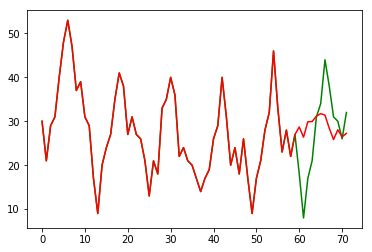

In [8]:
#Initial Prediction 

overall_loss=[]
batch=next(iter(test_dl))
inp=batch[0].float()#.unsqueeze(2)
out=batch[1].float()#.unsqueeze(2).float()
shifts=batch[2].numpy()
pred=hw(inp,shifts)
plt.plot(torch.cat([inp[0],out[0,:]]).detach().numpy(),"g")
plt.plot(torch.cat([inp[0],pred[0,:]]).detach().numpy(),"r")
plt.show()

In [14]:
#Initial Loss RMSE 
(torch.mean((pred-out)**2))**(1/2)

tensor(2.9005, grad_fn=<PowBackward0>)

In [15]:
#Baseline Loss Predicting last value at each step
(torch.mean((inp[0][-1]-out)**2))**(1/2)

tensor(9.5917)

In [16]:
overall_loss_train=[]
overall_loss=[]

In [12]:
for j in tqdm(range(20)):
    loss_list_b=[]
    train_loss_list_b=[]
    #here we use batches of past, and to be forecasted value
    #batches are determined by a random start integer
    for batch in iter(train_dl):

        opti.zero_grad()
        inp=batch[0].float()#.unsqueeze(2)
        out=batch[1].float()#.unsqueeze(2).float()
        shifts=batch[2].numpy()
        #it returns the whole sequence atm 
        pred=hw(inp,shifts)
        loss=(torch.mean((pred-out)**2))**(1/2)
        train_loss_list_b.append(loss.detach().cpu().numpy())
        
        loss.backward()
        opti.step()


    #here we use all the available values to forecast the future ones and eval on it
    for batch in iter(test_dl):
        inp=batch[0].float()#.unsqueeze(2)
        out=batch[1].float()#.unsqueeze(2).float()
        shifts=batch[2].numpy()
        pred=hw(inp,shifts)
        #loss=torch.mean(torch.abs(pred-out))
        loss=(torch.mean((pred-out)**2))**(1/2)
        loss_list_b.append(loss.detach().cpu().numpy())
    
 
    print(np.mean(loss_list_b))
    print(np.mean(train_loss_list_b))
    overall_loss.append(np.mean(loss_list_b))
    overall_loss_train.append(np.mean(train_loss_list_b))

  1%|          | 1/100 [00:02<03:27,  2.10s/it]

6.8607206
7.3957877


  2%|▏         | 2/100 [00:04<03:25,  2.10s/it]

4.0958314
4.4489546


  3%|▎         | 3/100 [00:06<03:22,  2.09s/it]

2.9072347
1.7616297


  4%|▍         | 4/100 [00:08<03:21,  2.10s/it]

2.90861
0.27803552


  5%|▌         | 5/100 [00:10<03:17,  2.08s/it]

2.8909032
0.07848331


  6%|▌         | 6/100 [00:12<03:14,  2.07s/it]

2.9040785
0.025534514


  7%|▋         | 7/100 [00:14<03:11,  2.06s/it]

2.9152913
0.02120905


  8%|▊         | 8/100 [00:16<03:08,  2.05s/it]

2.9007642
0.015477379


  9%|▉         | 9/100 [00:18<03:05,  2.03s/it]

2.903886
0.013104449


 10%|█         | 10/100 [00:20<03:03,  2.04s/it]

2.9012113
0.01664723


 11%|█         | 11/100 [00:22<03:00,  2.03s/it]

2.9098902
0.013082137


 12%|█▏        | 12/100 [00:24<02:58,  2.03s/it]

2.9086177
0.013396879


 13%|█▎        | 13/100 [00:26<02:58,  2.05s/it]

2.9079268
0.013137279


 14%|█▍        | 14/100 [00:28<02:55,  2.04s/it]

2.904755
0.011554496


 15%|█▌        | 15/100 [00:30<02:53,  2.04s/it]

2.9042325
0.01075287


 16%|█▌        | 16/100 [00:32<02:53,  2.07s/it]

2.8992906
0.014193204


KeyboardInterrupt: 

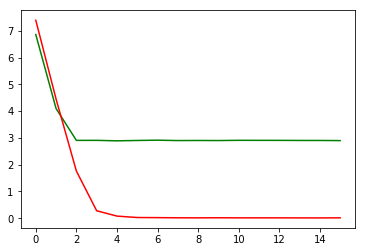

In [13]:
#Plot of Train and Validatiaon Loss, we nicely converge
plt.plot(overall_loss,"g")
plt.plot(overall_loss_train,"r")

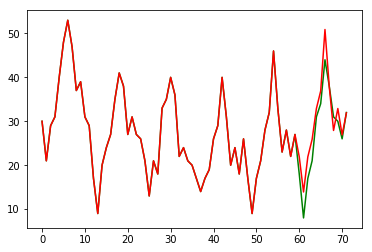

In [17]:
#Forecasting on the Validation set

batch=next(iter(test_dl))
inp=batch[0].float()#.unsqueeze(2)
out=batch[1].float()#.unsqueeze(2).float()
shifts=batch[2].numpy()
pred=hw(torch.cat([inp,out],dim=1),shifts)

#plt.plot(torch.cat([inp,out,pred],dim=1)[0].detach().numpy(),"r")


plt.plot(torch.cat([inp[0],out[0,:]]).detach().numpy(),"g")
plt.plot(torch.cat([inp[0],pred[0,:]]).detach().numpy(),"r")
plt.show()

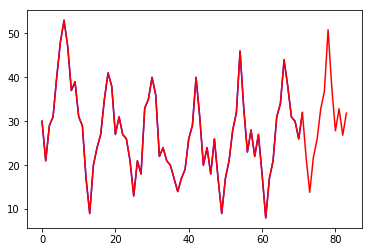

In [34]:
#Forecasting to the Future looks good.

batch=next(iter(test_dl))
inp=batch[0].float()#.unsqueeze(2)
out=batch[1].float()#.unsqueeze(2).float()
shifts=batch[2].numpy()

pred=hw(torch.cat([inp,out],dim=1),shifts)
plt.plot(torch.cat([inp,out],dim=1)[0].detach().numpy(),"b")
plt.plot(torch.cat([inp,out,pred],dim=1)[0].detach().numpy(),"r")


plt.show()

In [37]:
param_list=[]
for params in hw.parameters():
    param_list.append(params)
param_list=torch.sigmoid(params[0:2]).detach().numpy()

param_list

array([0.4233447 , 0.37306103], dtype=float32)